# **Watermarking a Summarization Model**

### *Colab Installs*

In [ ]:
!pip install datasets

In [ ]:
!pip install rouge-score

### *Dependencies, etc.*

In [15]:
from datasets import load_dataset
from __future__ import annotations
import collections
from math import sqrt
from rouge_score import rouge_scorer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from IPython.display import display
import torch
from torch import Tensor
from tokenizers import Tokenizer
from transformers import LogitsProcessor, BartTokenizer, BartForConditionalGeneration, LogitsProcessorList
from nltk.util import ngrams

### *Watermark Algorithm's Base*

>  
- Seeds the random number generator
    - *Step 2 in Algorithm 2 (Soft Red List)*
- Partitioning the vocabulary into a **green list** *G* and a **red list** *R*
    - *Step 3 in Algorithm 2 (Soft Red List)*

In [3]:
class WatermarkBase:
    def __init__(
        self,
        vocab: list[int] = None,
        gamma: float = 0.5,
        delta: float = 2.0,
        seeding_scheme: str = "simple_1",  # default
        hash_key: int = 15485863,  # just a large prime number to create a rng seed with sufficient bit width
        select_green_tokens: bool = True,
    ):

        # watermarking parameters
        self.vocab = vocab
        self.vocab_size = len(vocab)
        self.gamma = gamma
        self.delta = delta
        self.seeding_scheme = seeding_scheme
        self.rng = None
        self.hash_key = hash_key
        self.select_green_tokens = select_green_tokens

    def _seed_rng(self, input_ids: torch.LongTensor, seeding_scheme: str = None) -> None:
        if seeding_scheme is None:
            seeding_scheme = self.seeding_scheme

        if seeding_scheme == "simple_1":
            assert input_ids.shape[-1] >= 1, f"seeding_scheme={seeding_scheme} requires at least a 1 token prefix sequence to seed rng"
            prev_token = input_ids[-1].item()
            self.rng.manual_seed(self.hash_key * prev_token)
        else:
            raise NotImplementedError(f"Unexpected seeding_scheme: {seeding_scheme}")
        return

    def _get_greenlist_ids(self, input_ids: torch.LongTensor) -> list[int]:
        '''
        seed the rng using the previous tokens/prefix, according to the seeding_scheme
        '''
        self._seed_rng(input_ids)

        greenlist_size = int(self.vocab_size * self.gamma)
        vocab_permutation = torch.randperm(self.vocab_size, device=input_ids.device, generator=self.rng)
        if self.select_green_tokens:
            greenlist_ids = vocab_permutation[:greenlist_size]
        else:  # select green vs red
            greenlist_ids = vocab_permutation[(self.vocab_size - greenlist_size) :]
        return greenlist_ids

### *Watermark Logits Processor*

>  
- Calculates a mask for the **greenlist** tokens, which will be selected by the model during text generation
- Applies a bias to the logits (`scores`) of tokens identified as part of the **greenlist**. By adding a specified bias (`greenlist_bias`) to the scores of **greenlist** tokens
    - *Step 4 in Algorithm 2 (Soft Red List)*

In [4]:
class WatermarkLogitsProcessor(WatermarkBase, LogitsProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def _calc_greenlist_mask(self, scores: torch.FloatTensor, greenlist_token_ids) -> torch.BoolTensor:
        # did a quick fix for out-of-bound indexing due to BART token in-length
        green_tokens_mask = torch.zeros_like(scores, dtype=torch.bool)
        vocab_size = scores.size(-1)

        for b_idx, token_ids in enumerate(greenlist_token_ids):
            valid_ids = [tid for tid in token_ids if tid < vocab_size]
            green_tokens_mask[b_idx, valid_ids] = 1

        return green_tokens_mask

    def _bias_greenlist_logits(self, scores: torch.Tensor, greenlist_mask: torch.Tensor, greenlist_bias: float) -> torch.Tensor:
        scores[greenlist_mask] = scores[greenlist_mask] + greenlist_bias
        return scores

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:
        if self.rng is None:
            self.rng = torch.Generator(device=input_ids.device)

        batched_greenlist_ids = [None for _ in range(input_ids.shape[0])]

        for b_idx in range(input_ids.shape[0]):
            greenlist_ids = self._get_greenlist_ids(input_ids[b_idx])
            batched_greenlist_ids[b_idx] = greenlist_ids

        green_tokens_mask = self._calc_greenlist_mask(scores=scores, greenlist_token_ids=batched_greenlist_ids)

        scores = self._bias_greenlist_logits(scores=scores, greenlist_mask=green_tokens_mask, greenlist_bias=self.delta)
        return scores

### *Watermark Detector*

>  
- Parameters: the `device`, the `tokenizer` used for processing text, a threshold for `z-score` *(beyond which a watermark is considered detected)*, normalization, and flags for handling repeated bigrams
- Calculates the `z-score` to determine the statistical significance of the observed count of green tokens versus the expected count under the null hypothesis
    - *Equation (2) in the paper*
- Converts the `z-score` into a `p-value`, which represents the probability of observing the given or more extreme outcome under the null hypothesis
    - *(A lower `p-value` indicates a higher likelihood that the observed data did not occur by chance, supporting the presence of a watermark)*
- Returns a dictionary with the detection result, including `prediction` (*True* if the watermark is detected) and `confidence` *(1 - p_value)*

In [5]:
class WatermarkDetector(WatermarkBase):
    def __init__(
        self,
        *args,
        device: torch.device = None,
        tokenizer: Tokenizer = None,
        z_threshold: float = 4.0,
        normalizers: list[str] = ["unicode"],
        ignore_repeated_bigrams: bool = True,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        assert device, "Must pass device"
        assert tokenizer, "Need an instance of the generating tokenizer to perform detection"

        self.tokenizer = tokenizer
        self.device = device
        self.z_threshold = z_threshold
        self.rng = torch.Generator(device=self.device)

        if self.seeding_scheme == "simple_1":
            self.min_prefix_len = 1
        else:
            raise NotImplementedError(f"Unexpected seeding_scheme: {self.seeding_scheme}")

        self.normalizers = []
        for normalization_strategy in normalizers:
            self.normalizers.append(normalization_strategy_lookup(normalization_strategy))

        self.ignore_repeated_bigrams = ignore_repeated_bigrams
        if self.ignore_repeated_bigrams:
            assert self.seeding_scheme == "simple_1", "No repeated bigram credit variant assumes the single token seeding scheme."

    def _compute_z_score(self, observed_count, T):
        expected_count = self.gamma
        numer = observed_count - expected_count * T
        denom = sqrt(T * expected_count * (1 - expected_count))
        z = numer / denom
        return z

    def _compute_p_value(self, z):
        p_value = scipy.stats.norm.sf(z)
        return p_value

    def _score_sequence(
        self,
        input_ids: Tensor,
        return_num_tokens_scored: bool = True,
        return_num_green_tokens: bool = True,
        return_green_fraction: bool = True,
        return_green_token_mask: bool = False,
        return_z_score: bool = True,
        return_p_value: bool = True,
    ):
        if self.ignore_repeated_bigrams:
            '''
            Method that only counts a green/red hit once per unique bigram.
            New num total tokens scored (T) becomes the number unique bigrams.
            We iterate over all unqiue token bigrams in the input, computing the greenlist
            induced by the first token in each, and then checking whether the second
            token falls in that greenlist.
            '''
            assert return_green_token_mask is False, "Can't return the green/red mask when ignoring repeats."
            bigram_table = {}
            token_bigram_generator = ngrams(input_ids.cpu().tolist(), 2)
            freq = collections.Counter(token_bigram_generator)
            num_tokens_scored = len(freq.keys())
            for idx, bigram in enumerate(freq.keys()):
                prefix = torch.tensor([bigram[0]], device=self.device)  # expects a 1-d prefix tensor on the randperm device
                greenlist_ids = self._get_greenlist_ids(prefix)
                bigram_table[bigram] = True if bigram[1] in greenlist_ids else False
            green_token_count = sum(bigram_table.values())
        else:
            num_tokens_scored = len(input_ids) - self.min_prefix_len
            if num_tokens_scored < 1:
                raise ValueError(
                    (
                        f"Must have at least {1} token to score after "
                        f"the first min_prefix_len={self.min_prefix_len} tokens required by the seeding scheme."
                    )
                )
            '''
            Standard method:
            Since we generally need at least 1 token (for the simplest scheme)
            we start the iteration over the token sequence with a minimum
            num tokens as the first prefix for the seeding scheme,
            and at each step, compute the greenlist induced by the
            current prefix and check if the current token falls in the greenlist.
            '''
            green_token_count, green_token_mask = 0, []
            for idx in range(self.min_prefix_len, len(input_ids)):
                curr_token = input_ids[idx]
                greenlist_ids = self._get_greenlist_ids(input_ids[:idx])
                if curr_token in greenlist_ids:
                    green_token_count += 1
                    green_token_mask.append(True)
                else:
                    green_token_mask.append(False)

        score_dict = dict()
        if return_num_tokens_scored:
            score_dict.update(dict(num_tokens_scored=num_tokens_scored))
        if return_num_green_tokens:
            score_dict.update(dict(num_green_tokens=green_token_count))
        if return_green_fraction:
            score_dict.update(dict(green_fraction=(green_token_count / num_tokens_scored)))
        if return_z_score:
            score_dict.update(dict(z_score=self._compute_z_score(green_token_count, num_tokens_scored)))
        if return_p_value:
            z_score = score_dict.get("z_score")
            if z_score is None:
                z_score = self._compute_z_score(green_token_count, num_tokens_scored)
            score_dict.update(dict(p_value=self._compute_p_value(z_score)))
        if return_green_token_mask:
            score_dict.update(dict(green_token_mask=green_token_mask))

        return score_dict

    def detect(
        self,
        text: str = None,
        tokenized_text: list[int] = None,
        return_prediction: bool = True,
        return_scores: bool = True,
        z_threshold: float = None,
        **kwargs,
    ) -> dict:

        assert (text is not None) ^ (tokenized_text is not None), "Must pass either the raw or tokenized string"
        if return_prediction:
            kwargs["return_p_value"] = True  # to return the "confidence":=1-p of positive detections

        # run optional normalizers on text
        for normalizer in self.normalizers:
            text = normalizer(text)
        if len(self.normalizers) > 0:
            print(f"Text after normalization:\n\n{text}\n")

        if tokenized_text is None:
            assert self.tokenizer is not None, (
                "Watermark detection on raw string ",
                "requires an instance of the tokenizer ",
                "that was used at generation time.",
            )
            tokenized_text = self.tokenizer(text, return_tensors="pt", add_special_tokens=False)["input_ids"][0].to(self.device)
            if tokenized_text[0] == self.tokenizer.bos_token_id:
                tokenized_text = tokenized_text[1:]
        else:
            # try to remove the bos_tok at beginning if it's there
            if (self.tokenizer is not None) and (tokenized_text[0] == self.tokenizer.bos_token_id):
                tokenized_text = tokenized_text[1:]

        # call score
        output_dict = {}
        score_dict = self._score_sequence(tokenized_text, **kwargs)
        if return_scores:
            output_dict.update(score_dict)
        # if passed return_prediction then perform the hypothesis test and return the outcome
        if return_prediction:
            z_threshold = z_threshold if z_threshold else self.z_threshold
            assert z_threshold is not None, "Need a threshold in order to decide outcome of detection test"
            output_dict["prediction"] = score_dict["z_score"] > z_threshold
            if output_dict["prediction"]:
                output_dict["confidence"] = 1 - score_dict["p_value"]

        return output_dict

### *CNN/DailyMail Dataset + BART Model*

In [ ]:
dataset = load_dataset("cnn_dailymail", "3.0.0", split="test[:1%]")
article = dataset[1]["article"]

tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

### *Generating Standard and Watermaked Summary*
>
- Tokenizes an example input article, `max_length` ensures that the input is truncated to fit the model's size limit, and `return_tensors` specifies that the output should be PyTorch tensors
- Initializes the `WatermarkLogitsProcessor` with the model's `vocab`, parameters for the watermarking algorithm: `gamma, delta`, and the `seeding_scheme`
- Generates a standard summary for the input article using the model's `generate` function, with specified parameters for the maximum and minimum length, length penalty, and `num_beams` for beam search
- Generates a watermarked summary using the same generation parameters as the standard summary, but with the addition of the `logits_processor`, which applies the watermarking logic during generation
- Prints both the standard and watermarked summaries for comparison, illustrating the effect of the watermarking process on the generated text

> *This code cell effectively demonstrates the watermark embedding process in text generation and provides a clear example of how watermarked text compares to standard text generation outputs*

In [7]:
tokenized_input = tokenizer([article], max_length=1024, return_tensors="pt", truncation=True)

watermark_processor = WatermarkLogitsProcessor(vocab=list(tokenizer.get_vocab().values()),
                                                    gamma=0.25,
                                                    delta=4.0,
                                                    seeding_scheme="simple_1",
                                                    select_green_tokens=True)


summary_ids = model.generate(
    tokenized_input["input_ids"],
    max_length=150,
    min_length=40,
    length_penalty=2.0,
    num_beams=4
)
summary = tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

watermark_summary_ids = model.generate(
    tokenized_input["input_ids"],
    max_length=150,
    min_length=40,
    length_penalty=2.0,
    num_beams=4,
    logits_processor=LogitsProcessorList([watermark_processor])
)
watermark_summary = tokenizer.batch_decode(watermark_summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

print("Standard Summary:", summary)
print("Watermarked Summary:", watermark_summary)

Standard Summary: Theia, a one-year-old bully breed mix, was hit by a car and buried in a field. Four days after her apparent death, the dog managed to stagger to a nearby farm. She suffered a dislocated jaw, leg injuries and a caved-in sinus cavity. She still requires surgery to help her breathe.
Watermarked Summary: Bully-mix dog reportedly hit by vehicle and hit on the head by hammer and buried. The stray dog is only 1, but was left badly injured in the attack. She was discovered days after the attack and rushed to an animal hospital in Washington. Her foster mom has now raised more than $10,000 to treat her injuries and put her up for adoption.


### *Detecting Watermarked Summary*

In [8]:
watermark_detector = WatermarkDetector(vocab=list(tokenizer.get_vocab().values()),
                                        gamma=0.25,
                                        seeding_scheme="simple_1",
                                        tokenizer=tokenizer,
                                        device=model.device,
                                        z_threshold=4.0,
                                        normalizers=[],
                                        ignore_repeated_bigrams=False,
                                        select_green_tokens = True)

score_dict = watermark_detector.detect(watermark_summary)
score_dict

{'num_tokens_scored': 73,
 'num_green_tokens': 64,
 'green_fraction': 0.8767123287671232,
 'z_score': 12.365994024710593,
 'p_value': 1.9962081936830222e-35,
 'prediction': True,
 'confidence': 1.0}

### *Generating and Detecting over 1% of CNN/DailyMail Dataset*

>
- Iterates over all available 115 articles in the subset; for each article, it performs tokenization, generates a watermarked summary, detects the presence of the watermark, and collects the results
- This structure allows for an aggregated view of how the watermarking process affects various texts and the efficacy of the detection method
- The results are converted into a pandas `DataFrame` for better readability and analysis; `DataFrame` display options are set to ensure no information is truncated when visualizing the results, providing an overview of the watermarking process's outcomes across different articles

> *This cell effectively encapsulates the entire process of embedding watermarks in text, from generation through detection, and presents the results in a structured and easily interpretable format*

In [9]:
results = []

for i in range(115):
    article = dataset[i]["article"]
    tokenized_input = tokenizer([article], max_length=1024, return_tensors="pt", truncation=True)

    watermark_summary_ids = model.generate(
        tokenized_input["input_ids"],
        max_length=150,
        min_length=40,
        length_penalty=2.0,
        num_beams=4,
        logits_processor=LogitsProcessorList([watermark_processor])
    )
    watermark_summary = tokenizer.batch_decode(watermark_summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

    score_dict = watermark_detector.detect(watermark_summary)

    results.append({
        'summary': watermark_summary,
        'z_score': score_dict['z_score'],
        'p_value': score_dict['p_value'],
        'prediction': score_dict['prediction'],
    })

results_df = pd.DataFrame(results)

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

display(results_df)

,summary,z_score,p_value,prediction
0,Palestinian Authority formally becomes the 123rd member of the International Criminal Court. The move gives the court jurisdiction over alleged crimes in the territories. The ICC opened an preliminary inquiry in January into the situation in the territory. The inquiry opened the way for potential probes into Israelis.,7.686151,7.581354e-15,True
1,"Bully-mix dog reportedly hit by vehicle and hit on the head by hammer and buried. The stray dog is only 1, but was left badly injured in the attack. She was discovered days after the attack and rushed to an animal hospital in Washington. Her foster mom has now raised more than $10,000 to treat her injuries and put her up for adoption.",12.365994,1.996208e-35,True
2,Iran's foreign minister may be in the spotlight for a good reason. Mohammed Javad Zarif's background is less well-known than you may realize. Zarif was arrested over a charitable foundation in the US.,8.730534,1.267366e-18,True
3,"Five were released from Nebraska Medicine and have already left. They were exposed to Ebola in Sierra Leone. None developed virus but one had heart issue. They are working with Partners in Health, who are working in the Sierra Leone area.",9.209094,1.644449e-20,True
4,"Duke students will face an investigation, student affairs official says. The University of North Carolina is investigating whether other people were involved in the case. The student has now been identified and admitted putting the noose on the branch. The students are still searching for any other suspects, authorities say.",8.182495,1.390137e-16,True
5,"Boehner Trey Moses, who played college ball for a school team and has Down syndrome, made theposal in class. Photos of the students going viral online were posted by one teacher. The teen got the OK from both the students parents and his basketball coach, who are proud of the act.",10.898867,5.835042e-28,True
6,"Governments using the death penalty against terrorism, says Amnesty International's annual report. The annual report catalogs the use of the measure as a punitive measure globally, and notes mixed signs. The number of executions is down by 22% worldwide in the past year, and most regions appear to have seen declines. China remains the top offender for death penalty use.",11.455088,1.108686e-30,True
7,"Coroner preliminary assessment: No foul play involved in the death of Getty. Police spokesman: There's no indication there were foul plays, says the death appeared to be natural causes. The 46-year-old Getty, who had ""Several health issues"" found on side in home, was discovered by roommate, KTLA reports.",9.953997,1.211269e-23,True
8,Super typhoons usually carry 150 mph winds but has now been downgraded. Authorities take preemptive measures to prevent flash floods and landslides from occurring. Authorities ban outdoor activities in certain areas in thePhilippine island. The storm expected to make a landfall early Sunday morning.,9.754535,8.820405e-23,True
9,"Drew Carey returns as host of the ""The Price Is Right"" game show for one last time. The popular TV game show aired on March 31 on the CW, where it is broadcast nightly.",9.337453,4.933950e-21,True


### *ROUGE Evaluation*

In [42]:
reference_summaries = []

for i in range(115):
    article = dataset[i]["article"]
    tokenized_input = tokenizer([article], max_length=1024, return_tensors="pt", truncation=True)

    standard_summary_ids = model.generate(
        tokenized_input["input_ids"],
        max_length=150,
        min_length=40,
        length_penalty=2.0,
        num_beams=4
    )
    standard_summary = tokenizer.batch_decode(standard_summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

    reference_summaries.append(standard_summary)

In [48]:
from rouge_score import rouge_scorer

watermarked_summaries = results_df["summary"].tolist()

scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
rouge_scores = [scorer.score(ref, gen) for ref, gen in zip(reference_summaries, watermarked_summaries)]

rouge_stats = {
    "ROUGE-N": ["rouge1", "rouge2", "rougeL"],
    "Average F1": [np.mean([score[rouge].fmeasure for score in rouge_scores]) for rouge in ["rouge1", "rouge2", "rougeL"]],
    "Median F1": [np.median([score[rouge].fmeasure for score in rouge_scores]) for rouge in ["rouge1", "rouge2", "rougeL"]],
    "Std F1": [np.std([score[rouge].fmeasure for score in rouge_scores]) for rouge in ["rouge1", "rouge2", "rougeL"]]
}

rouge_df = pd.DataFrame(rouge_stats)
rouge_df

,ROUGE-N,Average F1,Median F1,Std F1
0,rouge1,0.368736,0.363636,0.094219
1,rouge2,0.117227,0.094118,0.086646
2,rougeL,0.248329,0.233766,0.091176


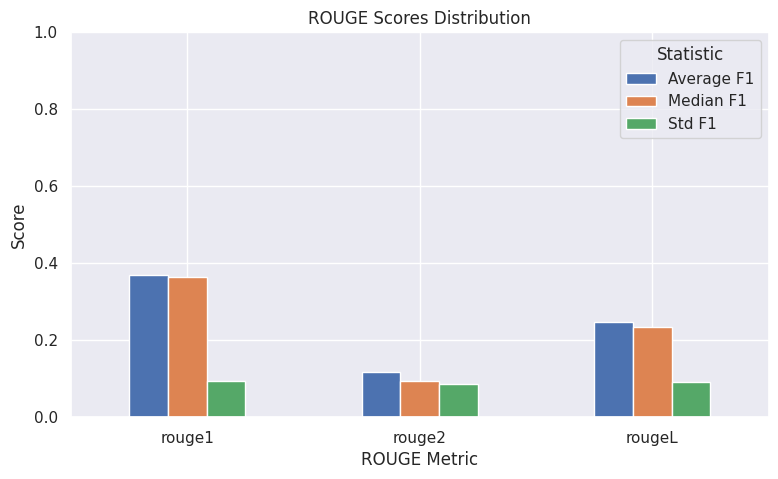

In [44]:
sns.set(style="darkgrid")
rouge_df.set_index("ROUGE-N").iloc[:, :3].plot(kind="bar", figsize=(9, 5), ylim=(0, 1))
plt.title("ROUGE Scores Distribution")
plt.xlabel("ROUGE Metric")
plt.ylabel("Score")
plt.legend(title="Statistic", labels=["Average F1", "Median F1", "Std F1"])
plt.xticks(rotation=0)
plt.show()